In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Load Data
file_path = 'encoded_resampled_dataset.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 2: Separate Features and Targets
X = data.drop(columns=['clarity', 'color', 'cut'])  # Features
Y = data[['clarity', 'color', 'cut']]  # Multi-label targets

# Step 3: Convert Multi-Label Targets to Single-Label
Y = Y.values.argmax(axis=1)  # Convert to single-label multi-class by argmax

# Step 4: Split Data into Training, Validation, and Test Sets
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 6: Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 7: Define Hyperparameter Distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],  # Fixed 'auto' issue
    'bootstrap': [True, False],
}

# Step 8: Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Step 9: RandomizedSearchCV for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Step 10: Fit the RandomizedSearchCV to the Training Data
random_search.fit(X_train_pca, Y_train)

# Step 11: Use the Best Estimator from RandomizedSearchCV
best_rf = random_search.best_estimator_

# Step 12: Predictions on Train, Validation, and Test Sets
Y_train_pred = best_rf.predict(X_train_pca)
Y_val_pred = best_rf.predict(X_val_pca)
Y_test_pred = best_rf.predict(X_test_pca)

# Step 13: Evaluate the Tuned Model with F1-score, Accuracy, Precision, and Recall (Macro Average)
# Train Metrics
precision_train = precision_score(Y_train, Y_train_pred, average='macro')
recall_train = recall_score(Y_train, Y_train_pred, average='macro')
accuracy_train = accuracy_score(Y_train, Y_train_pred)
f1_train = f1_score(Y_train, Y_train_pred, average='macro')

# Validation Metrics
precision_val = precision_score(Y_val, Y_val_pred, average='macro')
recall_val = recall_score(Y_val, Y_val_pred, average='macro')
accuracy_val = accuracy_score(Y_val, Y_val_pred)
f1_val = f1_score(Y_val, Y_val_pred, average='macro')

# Test Metrics
precision_test = precision_score(Y_test, Y_test_pred, average='macro')
recall_test = recall_score(Y_test, Y_test_pred, average='macro')
accuracy_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, average='macro')

# Step 14: Print the Metrics for Train, Validation, and Test Sets
print("Train Metrics:")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")

print("\nValidation Metrics:")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")

print("\nTest Metrics:")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Train Metrics:
Precision: 0.9893
Recall: 0.8657
Accuracy: 0.9882
F1 Score: 0.9197

Validation Metrics:
Precision: 0.9074
Recall: 0.7671
Accuracy: 0.9776
F1 Score: 0.8269

Test Metrics:
Precision: 0.9114
Recall: 0.7433
Accuracy: 0.9759
F1 Score: 0.8114


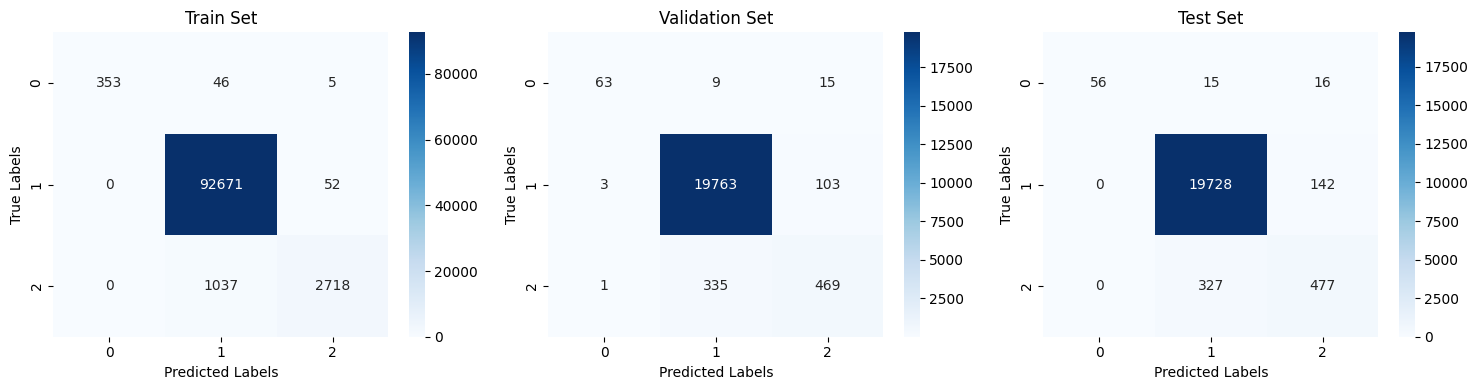

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=np.unique(Y), yticklabels=np.unique(Y), ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Adjust size to keep plots small

# Plot confusion matrices for Train, Validation, and Test sets
plot_confusion_matrix(axes[0], Y_train, Y_train_pred, "Train Set")
plot_confusion_matrix(axes[1], Y_val, Y_val_pred, "Validation Set")
plot_confusion_matrix(axes[2], Y_test, Y_test_pred, "Test Set")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


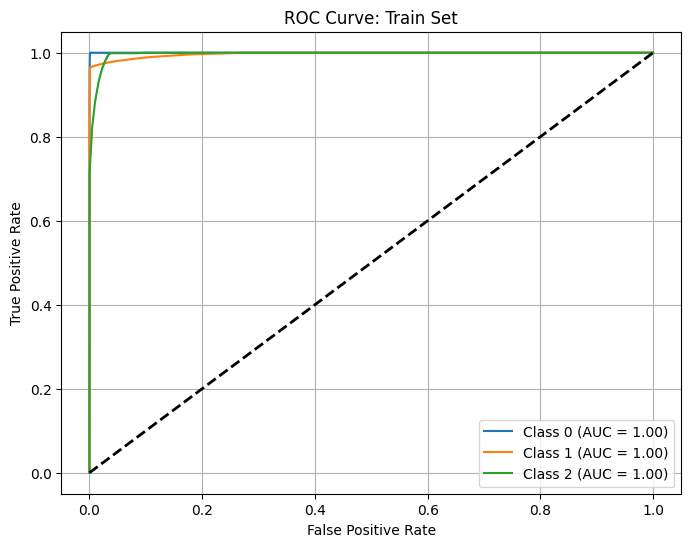

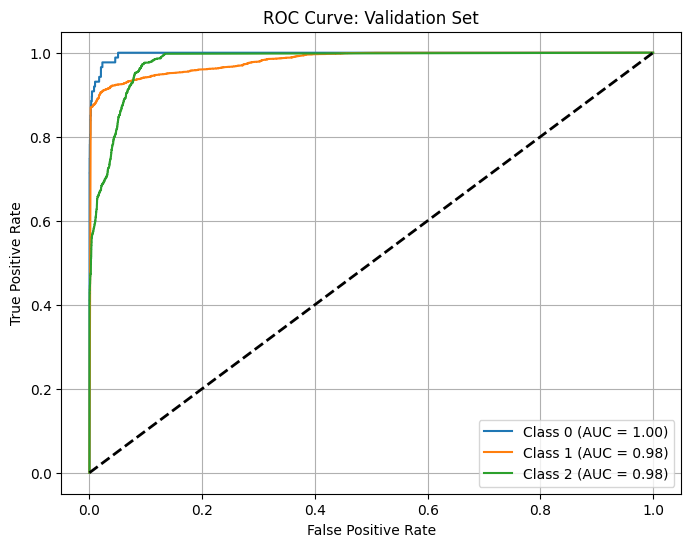

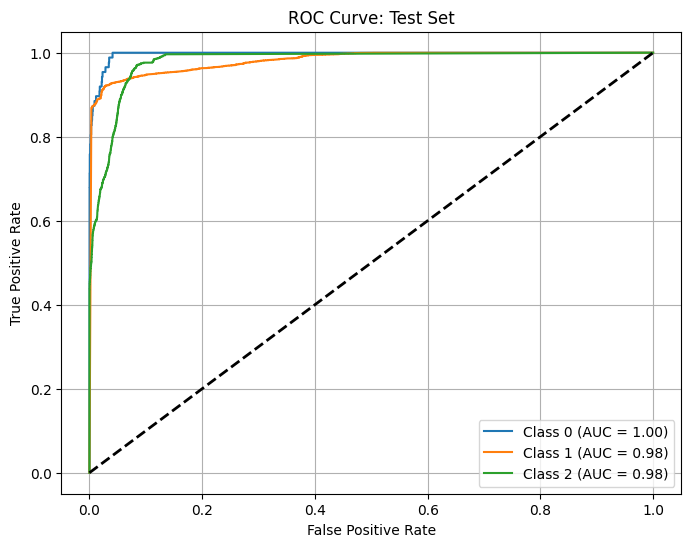

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC
n_classes = len(np.unique(Y))
Y_train_bin = label_binarize(Y_train, classes=np.unique(Y))
Y_val_bin = label_binarize(Y_val, classes=np.unique(Y))
Y_test_bin = label_binarize(Y_test, classes=np.unique(Y))

# Get predicted probabilities
Y_train_prob = best_rf.predict_proba(X_train_pca)
Y_val_prob = best_rf.predict_proba(X_val_pca)
Y_test_prob = best_rf.predict_proba(X_test_pca)

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, title):
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC curve for Train, Validation, and Test sets
plot_roc_curve(Y_train_bin, Y_train_prob, "ROC Curve: Train Set")
plot_roc_curve(Y_val_bin, Y_val_prob, "ROC Curve: Validation Set")
plot_roc_curve(Y_test_bin, Y_test_prob, "ROC Curve: Test Set")
